# **Airplane Price Prediction**

In this notebook i will work with data to predict airplane prices.

The first step is import all library to start.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split,ShuffleSplit,cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import mlflow
from mlflow.models import infer_signature

### Import data

In [3]:
df = pd.read_csv('data_analysed.csv')

In [4]:
class Numeric_Columns_Names:
    #method for parameters
    def __init__ (self, df, y):
        self.df = df
        self.y = y

    #method to exclude all object values to the df
    def exclude (self):
        #Drop the depende variable column
        numeric_columns = self.df.drop(columns = self.y)
        #Exclude object columns
        numeric_columns = numeric_columns.select_dtypes(exclude = ['object'])
       #Convert columns names to a list
        numeric_column_names = numeric_columns.columns.tolist()
        print("The numeric independ variables are", numeric_column_names)
        return  numeric_column_names

num1 = Numeric_Columns_Names(df,'Price') #Creating a instance of the class
numf = num1.exclude() #Call the exclude method


The numeric independ variables are ['Unnamed: 0', 'HP or lbs thr ea engine', 'Max speed Knots', 'Rcmnd cruise Knots', 'Stall Knots dirty', 'Fuel gal/lbs', 'All eng rate of climb', 'Landing over 50ft', 'Empty weight lbs', 'Total_Length_in', 'Total_Span_in']


# Model

**Multiple Lineal Regression**

In [5]:
lm = LinearRegression()
lm

LinearRegression()

In [6]:
X = df[numf].drop(columns = ['Unnamed: 0'])
y = df['Price']

In [7]:
lm.fit(X, y)

LinearRegression()

In [8]:
Y_hat = lm.predict(X)
y_pred_lr = lm.predict(X)

In [9]:
train_x = np.asanyarray(X)
train_y = np.asanyarray(y)

regr = LinearRegression()
regr.fit(train_x, train_y)

#the coefficinets

print('Coefficents:', regr.coef_)

Coefficents: [  37.02508769 7273.17057253  459.75701677 2328.73626772   16.71017451
   47.17088117  -46.25847558    9.42340996  862.80042009 1682.82063292]


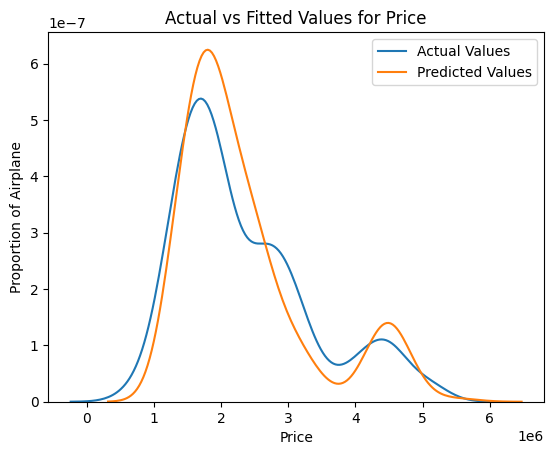

In [31]:
sns.kdeplot(df['Price'], label="Actual Values")
sns.kdeplot(Y_hat, label="Predicted Values")
plt.title('Actual vs Fitted Values for Price')
plt.xlabel('Price')
plt.ylabel('Proportion of Airplane')
plt.legend()

In [11]:
lm.fit(X,y)

LinearRegression()

In [12]:
r = lm.score(X, y)
r

0.9052806951630614

90% of the variation un price is explained by this simple lineal model.

In [13]:
r = lm.score(X, y)
mse = mean_squared_error(df['Price'], Y_hat)
std = df['Price'].std()
mean = df['Price'].mean()
var = df['Price'].var()

print('The std', std)
print('The mean', mean)
print('The mse', mse/100000000)
print ('The r2',r )
print('The variace',var)
print(mse/var)

The std 1009700.0042613782
The mean 2336964.163090129
The mse 963.5854961791705
The r2 0.9052806951630614
The variace 1019494098605.4271
0.09451604452612974


The MSE of a prediction is a 0.09 times the variance of the all data. Ok i think the multiple linear regresion is a simple good form to predict the airplace price. The next step is split the data in test and train, train a model with de train data and see the output.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Prédire les valeurs sur l'ensemble de test
y_pred = lm.predict(X_test)

# Calculer l'erreur quadratique moyenne divisée par 100 millions
mse = mean_squared_error(y_test, y_pred)
print(f"Erreur quadratique moyenne (MSE): {mse/100000000}")

# Calculer l'erreur absolue moyenne
mae = mean_absolute_error(y_test, y_pred)
print(f"Erreur absolue moyenne (MAE): {mae}")

# Calculer le coefficient de détermination R²
r2 = r2_score(y_test, y_pred)
print(f"Coefficient de détermination (R²): {r2}")

var = df['Price'].var()
print(f"Coefficient de détermination (R²): {var}")


Erreur quadratique moyenne (MSE): 1007.902967735626
Erreur absolue moyenne (MAE): 243568.43348909606
Coefficient de détermination (R²): 0.9006195085903749


In [28]:
scores = cross_val_score(lm, X, y, cv=5) #validation croisée à 5 plis
print("Scores de précision pour chaque pli:", scores)
print("Précision moyenne:", scores.mean())

Scores de précision pour chaque pli: [0.80248758 0.91052131 0.54205461 0.80141543 0.35465623]
Précision moyenne: 0.6822270319627691


# D'autres modeles

In [17]:
# Searching Best Model Using GridSeacrhCV

def find_best_model(X,y):
    algos = {
        'linear_regression':{
            'model':LinearRegression(),
            'params':{
            }
        },
        'random_forest':{
            'model':RandomForestRegressor(),
            'params':{
                'n_estimators':range(100,400,100),
                'max_depth':[10,20,30,40,50],
                # 'min_samples_split':range(2,10,2),
                # 'min_samples_leaf':range(1,10,2)
            }
        },
        'decision_tree':{
            'model':DecisionTreeRegressor(),
            'params':{
                'splitter':['best','random'],
                'max_depth':[10,20,30],
                'min_samples_split':range(2,20,2),
                'min_samples_leaf':range(1,10,2)
             }
        },
        'Knearest_neighbour':{
            'model':KNeighborsRegressor(),
            'params':{
                'n_neighbors':[1,3,5,7]
             }
        },
        'SVR':{
            'model':SVR(),
            'params':{
                'C':[0.1,0.5,1,1.5,2]
             }
        },



    }

    scores = []

    cv = ShuffleSplit(n_splits=5,random_state=0,test_size=0.2)

    for model_name,config in algos.items():
        gs = GridSearchCV(config['model'],config['params'],cv=cv,return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'Model Name':model_name,
            'Best Score':gs.best_score_,
            'Best Params':gs.best_params_
        })

    return pd.DataFrame(scores)

In [18]:
# Find best scores for all Models
find_best_model(X,y)

,Model Name,Best Score,Best Params
0,linear_regression,0.899410,{}
1,random_forest,0.944309,"{'max_depth': 40, 'n_estimators': 200}"
2,decision_tree,0.923803,"{'max_depth': 20, 'min_samples_leaf': 3, 'min_..."
3,Knearest_neighbour,0.879217,{'n_neighbors': 5}
4,SVR,-0.145367,{'C': 2}


## Essayons donc le randomForest

In [19]:
rf = RandomForestRegressor(max_depth=30,n_estimators=200)

In [20]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, n_estimators=200)

In [21]:
y_pred_rf = rf.predict(X_test)

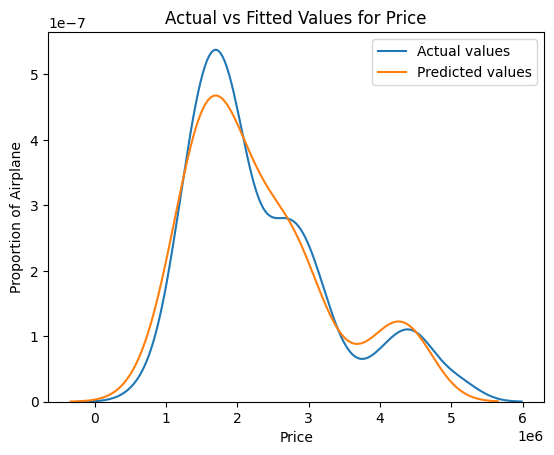

In [32]:
sns.kdeplot(df['Price'], label="Actual values")
sns.kdeplot(y_pred_rf, label="Predicted values")
plt.title('Actual vs Fitted Values for Price')
plt.xlabel('Price')
plt.ylabel('Proportion of Airplane')
plt.legend()

In [23]:
# Calculer l'erreur quadratique moyenne divisée par 100 millions
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Erreur quadratique moyenne (MSE): {mse_rf/100000000}")

# Calculer l'erreur absolue moyenne
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Erreur absolue moyenne (MAE): {mae_rf}")

# Calculer le coefficient de détermination R²
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Coefficient de détermination (R²): {r2_rf}")


Erreur quadratique moyenne (MSE): 766.8858728855054
Erreur absolue moyenne (MAE): 196940.46276595743
Coefficient de détermination (R²): 0.9243840951538386


In [29]:
scores_rf = cross_val_score(rf, X, y, cv=5) #validation croisée à 5 plis
print("Scores de précision pour chaque pli:", scores_rf)
print("Précision moyenne:", scores_rf.mean())

Scores de précision pour chaque pli: [0.80489679 0.91626998 0.5466474  0.86623574 0.91815392]
Précision moyenne: 0.81044076584975


# Monitoring

In [41]:
mlflow.set_experiment("E2")

<Experiment: artifact_location='file:///root/code/MugicaLaurendi/Certification/E2/Proto_2/mlruns/974578984653014572', creation_time=1712414354084, experiment_id='974578984653014572', last_update_time=1712414354084, lifecycle_stage='active', name='E2', tags={}>

In [42]:
# Start an MLflow run
with mlflow.start_run(run_name= "RF"):

    params = {
        "max_depth" : 30,
        "n_estimators" : 200
    }

    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    signature = infer_signature(X_train, rf.predict(X_train))

    mlflow.log_params(params)
    mlflow.log_metric("MSE / 100m", mse_rf/100000000)
    mlflow.log_metric("R2", r2_rf)

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=rf,
        artifact_path="plane_price_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="Random Forest",
    )

/root/.pyenv/versions/3.10.7/envs/certif_e2/lib/python3.10/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


/root/.pyenv/versions/3.10.7/envs/certif_e2/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/root/.pyenv/versions/3.10.7/envs/certif_e2/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'Random Forest' already exists. Creating a new version of this model...
Created version '7' of model 'Random Forest'.


In [43]:
# Start an MLflow run
with mlflow.start_run(run_name= "LR"):

    params = {}

    mse_lr = mean_squared_error(y_test, y_pred)
    r2_lr = r2_score(y_test, y_pred)
    signature = infer_signature(X_train, lm.predict(X_train))

    mlflow.log_params(params)
    mlflow.log_metric("MSE / 100m", mse_lr/100000000)
    mlflow.log_metric("R2", r2_lr)

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=lm,
        artifact_path="plane_price_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="Linear Regression",
    )

/root/.pyenv/versions/3.10.7/envs/certif_e2/lib/python3.10/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/root/.pyenv/versions/3.10.7/envs/certif_e2/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` 

## ML Flow UI

http://localhost:5000/

In [44]:
!mlflow ui

[2024-04-08 01:37:17 +0200] [2182] [INFO] Starting gunicorn 21.2.0
[2024-04-08 01:37:17 +0200] [2182] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2024-04-08 01:37:17 +0200] [2182] [ERROR] Retrying in 1 second.
[2024-04-08 01:37:18 +0200] [2182] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2024-04-08 01:37:18 +0200] [2182] [ERROR] Retrying in 1 second.
[2024-04-08 01:37:19 +0200] [2182] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2024-04-08 01:37:19 +0200] [2182] [ERROR] Retrying in 1 second.
[2024-04-08 01:37:20 +0200] [2182] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2024-04-08 01:37:20 +0200] [2182] [ERROR] Retrying in 1 second.
[2024-04-08 01:37:21 +0200] [2182] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2024-04-08 01:37:21 +0200] [2182] [ERROR] Retrying in 1 second.
[2024-04-08 01:37:22 +0200] [2182] [ERROR] Can't connect to ('127.0.0.1', 5000)
Running the mlflow server failed. Please see the logs above for details.
